In [1]:
import sys
import os
sys.path.append('/Users/adam2392/Documents/tvb/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import numpy as np
import pandas as pd
import scipy
from sklearn import cluster
import tvbsim

import processing.util as util
import processing.preprocessfft as preprocess

from natsort import natsorted

import tvbsim.util

%load_ext autoreload
%autoreload 2

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

In [4]:
MOVEDCONTACTS = 1

# if MOVEDCONTACTS:
#     datadir = '/home/adamli/data/output/frequencyanalysis/moved/'
# else:
#     datadir = '/home/adamli/data/output/frequencyanalysis/notmoved/'
if MOVEDCONTACTS:
    datadir = '/Volumes/ADAM LI/pydata/output/frequencyanalysis/'
else:
    datadir = '/Volumes/ADAM LI/pydata/output/frequencyanalysis/notmoved/'

metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

datafiles = os.listdir(datadir)
print('Moving contacts: ', MOVEDCONTACTS)
print(datafiles)

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
print(datafiles)

Moving contacts:  1
['.DS_Store', '._.DS_Store', 'varydistance', 'final_dataset']
['/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id001_ac_sim_nez1_npz1_dist4_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id001_ac_sim_nez1_npz1_dist3_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id001_ac_sim_nez1_npz1_dist2_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id001_ac_sim_nez1_npz1_dist5_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id002_cj_sim_nez1_npz1_dist7_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id014_rb_sim_nez1_npz1_dist1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id014_rb_sim_nez1_npz1_dist6_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id002_cj_sim_nez1_npz1_dist6_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistanc

In [5]:
patients = []
# get all patients in the dataset
for datafile in datafiles:
    filename = path_leaf(datafile)
    patient = '_'.join(filename.split('_')[0:2])
    if patient not in patients:
        patients.append(patient)
print(patients)

['id002_cj', 'id014_rb', 'id001_ac']


In [28]:
patient_dict = {}

'''
This code segment should only be ran once, to extract metadata for each patient, 
so it doesn't need to be done in the loop for FFT compression.
'''
# get all metadata for each patient
for patient in patients:
    project_dir = os.path.join(metadatadir, patient)
#     confile = os.path.join(project_dir, "connectivity.zip")

    # get the regions, and region_centers from connectivity
#     reader = util.ZipReader(confile)
#     region_centers = reader.read_array_from_file("centres", use_cols=(1, 2, 3))
#     regions = reader.read_array_from_file("centres", dtype=np.str, use_cols=(0,))
    
    # load in the vertices, normals and areas of gain matrix
    use_subcort = True
    verts, _, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)
    
    patient_dict['project_dir'] = project_dir
    patient_dict['regions'] = regions
    patient_dict['region_centers'] = region_centers
    patient_dict['surf_data'] = (verts, areas, regmap)

In [29]:
# establish frequency bands
freqbands = {
#     'deltatheta': [0,8],
#     'alpha': [8, 16],
#     'beta': [16, 30],
#     'gamma': [30,90],
#     'highgamma': [90, 500]
    'lowfreq': [0, 16],
    'midfreq': [16, 33],
    'gamma': [33, 90],
    'highgamma': [90, 501],
}

preprocessor = preprocess.PreProcess(datafiles=datafiles,
                                                   freqbands=freqbands)

In [59]:
print(seizuremarks)
print(timelens)
print(len(timelens))
print(len(seizuremarks))

[[(17591.0, 75874.0), (125307.0, 165845.0)], [(186829.0, 233520.0), (267896.0, 309582.0), (312259.0, 343478.0)], [(259569.0, 318848.0), (354619.0, 394492.0)], [(182795.0, 234888.0)], [(110728.0, 171307.0), (194867.0, 259666.0)], [(188889.0, 238157.0)], [(105039.0, 160234.0), (185114.0, 237601.0)], [(175904.0, 228474.0), (256277.0, 317791.0)], [(177321.0, 231898.0), (269268.0, 354049.0)]]
[168000, 240000, 162000, 92000, 169000, 86000, 158000, 160000, 195000]
9
9


In [62]:
# lists to store the list of tuples of seizure onset/offsets
seizuremarks = []

# list to store the last time point of each recording added in
timelens = []

for idx,datafile in enumerate(datafiles):
    powerbands, timepoints = preprocessor.compresspowermat(datafile)
    onsettimes, offsettimes = preprocessor.getseiztimes(datafile)
    
    metadata = preprocessor.loadmetadata(datafile)
    metadata['regions'] = regions
    metadata['region_centers'] = region_centers
    
    # get the last time point
    lasttimewin = timepoints[-1,:][1]+1
    timelens.append(lasttimewin)
    
    if idx > 0:
        onsettimes = list(np.asarray(onsettimes) + np.sum(timelens[0:idx-1]))
        offsettimes = list(np.asarray(offsettimes) + np.sum(timelens[0:idx-1]))
    seizuremarks_tuple = list(zip(onsettimes,offsettimes)) 
    seizuremarks.append(seizuremarks_tuple)
#     mapped_power_bands = preprocessor.projectpower_gain(powerbands,
#                                                         metadata,
#                                                        verts,
#                                                        areas,
#                                                        regmap)
#     print(mapped_power_bands.shape)
#     mapped_power_bands = preprocessor.projectpower_knn(powerbands,
#                                                         metadata)
#     print(mapped_power_bands.shape)
    mapped_power_bands = preprocessor.projectpower_invsquare(powerbands,
                                                        metadata)
#     print(onsettimes, offsettimes)
#     print(powerbands.keys())
#     print(powerbands[list(powerbands.keys())[0]].shape)
#     print(mapped_power_bands.shape)

    if idx == 0:
        condensed_power = mapped_power_bands
    else:
        condensed_power = np.concatenate((condensed_power, mapped_power_bands), axis=0)

print(condensed_power.shape)
print(seizuremarks)
print(timelens)

/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez1_npz1/id002_cj_sim_nez1_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez1_npz1/id014_rb_sim_nez1_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez1_npz1/id001_ac_sim_nez1_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez2_npz1/id002_cj_sim_nez2_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez2_npz1/id014_rb_sim_nez2_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez2_npz1/id001_ac_sim_nez2_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez3_npz1/id002_cj_sim_nez3_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez3_npz1/id014_rb_sim_nez3_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez3_npz1/id001_ac_sim_nez3_npz1_fftmodel.npz
(11431, 7, 12, 4)
[[(17591.0, 75874.0), (125307.0, 165845.0)], [(18829.0, 65520.0), (99896.0, 141582.0), (144259.0, 175478.0)], [(187569.0, 24684

In [65]:
# save all the condensed data
resultsdir = '/Volumes/ADAM LI/pydata/output/frequencyanalysis/final_dataset/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
metafilename = os.path.join(resultsdir, 'fft_dataset_invsquare_meta.npz')
filename = os.path.join(resultsdir, 'fft_dataset_invsquare.npz')

np.savez_compressed(filename, power=condensed_power,
                   seizuremarks=seizuremarks,
                   timelens=timelens,
                   datafiles=datafiles)

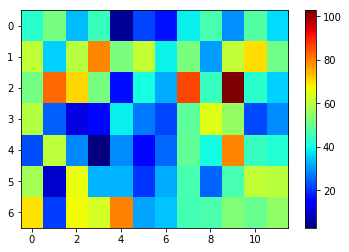

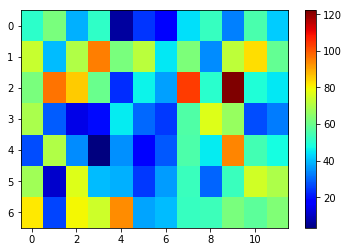

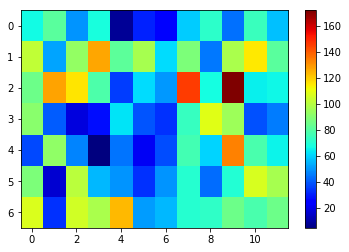

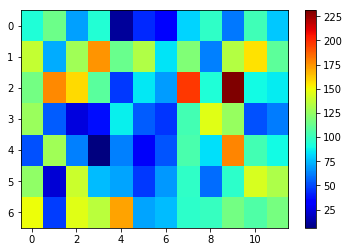

In [38]:
import matplotlib
import matplotlib.pyplot as plt

for i in range(4):
    plt.figure()
    plt.imshow(np.abs(mapped_power_bands[0,:,:,i]), cmap='jet', aspect='auto')
    plt.colorbar()
    plt.show()

# Add To Data Structure

If data is already stored, this code segment is meant for adding to that existing data structure (tensor) for training into the GPU.

In [44]:
datadir = '/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/'
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

datafiles = os.listdir(datadir)
print('Moving contacts: ', MOVEDCONTACTS)
print(datafiles)

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
print(datafiles)

patients = []
# get all patients in the dataset
for datafile in datafiles:
    filename = path_leaf(datafile)
    patient = '_'.join(filename.split('_')[0:2])
    if patient not in patients:
        patients.append(patient)
print(patients)

Moving contacts:  1
['nez1_npz1', 'nez2_npz1', 'nez3_npz1']
['/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez1_npz1/id002_cj_sim_nez1_npz1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez1_npz1/id014_rb_sim_nez1_npz1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez1_npz1/id001_ac_sim_nez1_npz1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez2_npz1/id002_cj_sim_nez2_npz1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez2_npz1/id014_rb_sim_nez2_npz1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez2_npz1/id001_ac_sim_nez2_npz1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez3_npz1/id002_cj_sim_nez3_npz1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez3_npz1/id014_rb_sim_nez3_npz1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyan

In [10]:
patient_dict = {}

'''
This code segment should only be ran once, to extract metadata for each patient, 
so it doesn't need to be done in the loop for FFT compression.
'''
# get all metadata for each patient
for patient in patients:
    project_dir = os.path.join(metadatadir, patient)
    confile = os.path.join(project_dir, "connectivity.zip")

    # get the regions, and region_centers from connectivity
    reader = util.ZipReader(confile)
    region_centers = reader.read_array_from_file("centres", use_cols=(1, 2, 3))
    regions = reader.read_array_from_file("centres", dtype=np.str, use_cols=(0,))
    
    # load in the vertices, normals and areas of gain matrix
    use_subcort = True
    verts, _, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)
    
    patient_dict['project_dir'] = project_dir
    patient_dict['regions'] = regions
    patient_dict['region_centers'] = region_centers
    patient_dict['surf_data'] = (verts, areas, regmap)

In [45]:
# establish frequency bands
freqbands = {
#     'deltatheta': [0,8],
#     'alpha': [8, 16],
#     'beta': [16, 30],
#     'gamma': [30,90],
#     'highgamma': [90, 500]
    'lowfreq': [0, 16],
    'midfreq': [16, 33],
    'gamma': [33, 90],
    'highgamma': [90, 501],
}

preprocessor = preprocess.PreProcess(datafiles=datafiles,
                                                   freqbands=freqbands)

In [2]:
# load up the previous data and get the corresponding metadata and data
resultsdir = '/Volumes/ADAM LI/pydata/output/frequencyanalysis/final_dataset/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
metafilename = os.path.join(resultsdir, 'fft_dataset_invsquare_meta.npz')
filename = os.path.join(resultsdir, 'fft_dataset_invsquare.npz')

data = np.load(filename)
power = data['power']
currseizuremarks = data['seizuremarks'].tolist()
currtimelens = data['timelens']
currdatafiles = data['datafiles'].tolist()

print(data.keys())

['power', 'seizuremarks', 'timelens', 'datafiles']


In [4]:
print(power.shape)
# print(currseizuremarks.shape)
# print(currtimelens.shape)
# print(currdatafiles.shape)

current_totaltime = np.sum(currtimelens)

print(currseizuremarks)
test = currseizuremarks[0]
print(test)
print(np.array(test))
# print(currseizuremarks.tolist())
print(currdatafiles)

(22862, 7, 12, 4)
[[(17591.0, 75874.0), (125307.0, 165845.0)], [(18829.0, 65520.0), (99896.0, 141582.0), (144259.0, 175478.0)], [(187569.0, 246848.0), (282619.0, 322492.0)], [(428795.0, 480888.0)], [(588728.0, 649307.0), (672867.0, 737666.0)], [(681889.0, 731157.0)], [(850039.0, 905234.0), (930114.0, 982601.0)], [(934904.0, 987474.0), (1015277.0, 1076791.0)], [(1092321.0, 1146898.0), (1184268.0, 1269049.0)], [(1615591.0, 1673874.0), (1723307.0, 1763845.0)], [(1616829.0, 1663520.0), (1697896.0, 1739582.0), (1742259.0, 1773478.0)], [(1617569.0, 1676848.0), (1712619.0, 1752492.0)], [(1618795.0, 1670888.0)], [(1616728.0, 1677307.0), (1700867.0, 1765666.0)], [(1617889.0, 1667157.0)], [(1617039.0, 1672234.0), (1697114.0, 1749601.0)], [(1615904.0, 1668474.0), (1696277.0, 1757791.0)], [(1615321.0, 1669898.0), (1707268.0, 1792049.0)]]
[(17591.0, 75874.0), (125307.0, 165845.0)]
[[ 17591.  75874.]
 [125307. 165845.]]
['/Volumes/ADAM LI/pydata/output/frequencyanalysis/nez1_npz1/id002_cj_sim_nez1_n

In [48]:
condensed_power = power
timelens = currtimelens
seizuremarks = currseizuremarks

for idx,datafile in enumerate(datafiles):
    powerbands, timepoints = preprocessor.compresspowermat(datafile)
    onsettimes, offsettimes = preprocessor.getseiztimes(datafile)
    
    metadata = preprocessor.loadmetadata(datafile)
    metadata['regions'] = regions
    metadata['region_centers'] = region_centers
    
    # get the last time point
    lasttimewin = timepoints[-1,:][1]+1
    timelens = np.append(timelens,lasttimewin)
    
    onsettimes = list(np.asarray(onsettimes) + np.sum(timelens[0:len(timelens)-idx]))
    offsettimes = list(np.asarray(offsettimes) + np.sum(timelens[0:len(timelens)-idx]))
    seizuremarks_tuple = list(zip(onsettimes,offsettimes)) 
    seizuremarks.append(seizuremarks_tuple)
#     seizuremarks = np.append(seizuremarks,seizuremarks_tuple)
#     mapped_power_bands = preprocessor.projectpower_gain(powerbands,
#                                                         metadata,
#                                                        verts,
#                                                        areas,
#                                                        regmap)
#     print(mapped_power_bands.shape)
#     mapped_power_bands = preprocessor.projectpower_knn(powerbands,
#                                                         metadata)
#     print(mapped_power_bands.shape)
    mapped_power_bands = preprocessor.projectpower_invsquare(powerbands,
                                                        metadata)
    condensed_power = np.concatenate((condensed_power, mapped_power_bands), axis=0)
    currdatafiles.append(datafile)

print(condensed_power.shape)
print(seizuremarks)
print(timelens)

/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez1_npz1/id002_cj_sim_nez1_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez1_npz1/id014_rb_sim_nez1_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez1_npz1/id001_ac_sim_nez1_npz1_fftmodel.npz


/Users/adam2392/Documents/dnn-unsupervised/dnn/processing/preprocessfft.py:227: RuntimeWarning: divide by zero encountered in true_divide
  Vr = 1/(ndr**2) # fall off as a function of r^2


/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez2_npz1/id002_cj_sim_nez2_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez2_npz1/id014_rb_sim_nez2_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez2_npz1/id001_ac_sim_nez2_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez3_npz1/id002_cj_sim_nez3_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez3_npz1/id014_rb_sim_nez3_npz1_fftmodel.npz
/Volumes/ADAM LI/pydata/output/frequencyanalysis/movedcontacts/nez3_npz1/id001_ac_sim_nez3_npz1_fftmodel.npz
(22862, 7, 12, 4)
[[(17591.0, 75874.0), (125307.0, 165845.0)], [(18829.0, 65520.0), (99896.0, 141582.0), (144259.0, 175478.0)], [(187569.0, 246848.0), (282619.0, 322492.0)], [(428795.0, 480888.0)], [(588728.0, 649307.0), (672867.0, 737666.0)], [(681889.0, 731157.0)], [(850039.0, 905234.0), (930114.0, 982601.0)], [(934904.0, 987474.0), (1015277.

In [51]:
# save all the condensed data
np.savez_compressed(filename, power=condensed_power,
                   seizuremarks=seizuremarks,
                   timelens=timelens,
                   datafiles=currdatafiles)